# Temporal Clustering and Classification of Students

In [91]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta, date
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import svm
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import calplot
import time
import math
import json
import sys
import os

In [2]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
from helpers.db_connector import MySQLConnector
from helpers.feature_extraction import *
from helpers.data_process import *
from helpers.db_query import *
from helpers.time import *

## Linear Algebra Dataset from Coursaware

Since Fall 2017, the stream of the EPFL's Linear Algebra course has been taught in a flipped format. The implementation of the flipped classroom was carried out in an incremental manner, as described below:

- **Year 2017-2018**: traditional manner (weeks 1-13) - flipped manner (week 14).
- **Year 2017-2018**: traditional manner (weeks 1-4, 10-14) - flipped manner (weeks 5-9).
- **Year 2019-2020**: traditional manner (weeks 1-4) - flipped manner (weeks 5-14).

### Identifying Students


The flipped course was offered only to volunteering students. The volunteers were collectively assigned into either the experimental and the control group. A stratified random sampling based on gender and the prior background (secondary educational level) of students were used.

In [4]:
%time user_data = getUserInfo()

Wall time: 656 ms


In [5]:
len(user_data.index)

1388

The initial data of volunteers was cleaned, and some participants were removed before we analyzed the data:
- The volunteering students who have not been graded were removed. 
- The repeating students were filtered out, where repeating students are those accessing videos in two different years. 
- The less active students, i.e., those who have provided less 60 interactions in the platform, were removed. 

In [6]:
graded = getGraded()
print('Removed ungraded students:', len(set(user_data['AccountUserID'])) - len(graded))
user_data = user_data[user_data['AccountUserID'].isin(graded)]

Removed ungraded students: 36


In [7]:
repeating = getRepeating()
user_data = user_data[~user_data['AccountUserID'].isin(repeating)]
print('Removed repeating students:', len(repeating))

Removed repeating students: 13


In [8]:
unactives = getUnactives()
user_data = user_data[~user_data['AccountUserID'].isin(unactives)]
print('Removed unactive students:', len(unactives))

Removed unactive students: 206


In this study, we will consider only those students who have completed the class in flipped mode. 

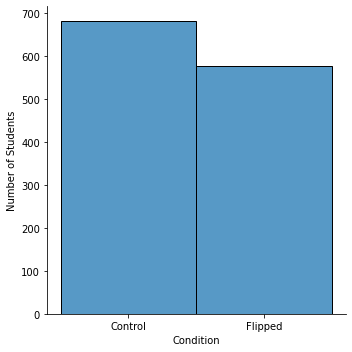

In [13]:
sns.displot(user_data, x='Condition')
plt.ylabel('Number of Students')
plt.show()

In [14]:
user_data = user_data[user_data['Condition'] == 'Flipped'].drop_duplicates(subset=['AccountUserID'], keep='first')

In [15]:
user_data.head()

,AccountUserID,Sciper,Round,Condition,District,Region,Country,Continent
1,46938,251818,Y2-2018-19,Flipped,Canton of Zürich,Central Europe,Switzerland,Europe
12,8402,262362,Y1-2017-18,Flipped,Canton of Zurich,Central Europe,Switzerland,Europe
14,9866,262628,Y1-2017-18,Flipped,Madrid,South West Europe,Spain,Europe
15,49638,262813,Y2-2018-19,Flipped,Vaud,Central Europe,Switzerland,Europe
19,11354,265904,Y1-2017-18,Flipped,Canton of Zurich,Central Europe,Switzerland,Europe


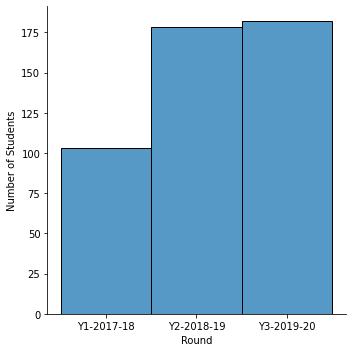

In [17]:
sns.displot(user_data.sort_values(by='Round'), x='Round')
plt.ylabel('Number of Students')
plt.show()

**N.B.** We are missing a range of important demographic attributes, such as the gender, the age, and the prior knowledge.

### Getting Students' Records

#### Video Clickstream Records

In [18]:
%time video_data = getVideoInfo()

Wall time: 27.9 s


We filter only the video events of students included in our study.

In [19]:
video_data = video_data[video_data['AccountUserID'].isin(user_data['AccountUserID'].values)]

In [20]:
video_data.head()

,AccountUserID,Round,EventType,TimeStamp,Title,Source
1,9695,Y1-2017-18,Video.Pause,2017-11-04 17:33:04,Leçon,https://www.youtube.com/watch?v=2tFXTRmEIQA
2,9845,Y1-2017-18,Video.Pause,2017-11-04 11:27:51,Leçon,https://www.youtube.com/watch?v=2tFXTRmEIQA
3,9668,Y1-2017-18,Video.Play,2018-01-10 15:19:16,Leçon,https://www.youtube.com/watch?v=2tFXTRmEIQA
4,14654,Y1-2017-18,Video.Play,2017-11-05 15:20:18,Leçon,https://www.youtube.com/watch?v=2tFXTRmEIQA
5,9725,Y1-2017-18,Video.Pause,2017-11-07 10:02:38,Leçon,https://www.youtube.com/watch?v=2tFXTRmEIQA


#### Problem Clickstream Records

In [25]:
%time problem_data = getProblemInfo()

Wall time: 13.2 s


We filter only the problem events of students included in our study.

In [26]:
problem_data = problem_data[problem_data['AccountUserID'].isin(user_data['AccountUserID'].values)]

In [27]:
problem_data.head()

,AccountUserID,Round,EventType,TimeStamp,ProblemType,MaximumSubmissions
0,9932,Y1-2017-18,Problem.Check,2017-10-28 12:52:16,Quiz,NaN
1,10157,Y1-2017-18,Problem.Check,2017-10-29 15:18:37,Quiz,NaN
3,9902,Y1-2017-18,Problem.Check,2017-10-29 13:49:23,Quiz,NaN
4,10217,Y1-2017-18,Problem.Check,2017-10-31 11:18:34,Quiz,NaN
5,10094,Y1-2017-18,Problem.Check,2017-10-30 10:26:40,Quiz,NaN


#### Exam Records

In [28]:
%time exam_data = getExamInfo()

Wall time: 1.31 s


We filter only the last exam grade of students included in our study.

In [29]:
exam_data['Grade'] = exam_data['Grade'].astype(float)

In [30]:
exam_data = exam_data[exam_data['AccountUserID'].isin(user_data['AccountUserID'].values)]

In [31]:
exam_data = exam_data.sort_values(['AccountUserID','GradeDate']).drop_duplicates(subset=['AccountUserID'], keep='last')

In [32]:
exam_data.head()

,AccountUserID,Round,Grade,GradeDate
4096,10007,Y2-2018-19,3.75,02.2019
3769,10031,Y1-2017-18,4.25,02.2018
4470,10034,Y1-2017-18,4.75,02.2018
2287,10040,Y1-2017-18,4.75,02.2018
13352,100402,Y3-2019-20,5.75,02.2020


#### Event Records

In [33]:
d1 = video_data[['AccountUserID','TimeStamp','EventType','Round']]
d2 = problem_data[['AccountUserID','TimeStamp','EventType','Round']]
data = d1.append(d2)

In [34]:
data.head()

,AccountUserID,TimeStamp,EventType,Round
1,9695,2017-11-04 17:33:04,Video.Pause,Y1-2017-18
2,9845,2017-11-04 11:27:51,Video.Pause,Y1-2017-18
3,9668,2018-01-10 15:19:16,Video.Play,Y1-2017-18
4,14654,2017-11-05 15:20:18,Video.Play,Y1-2017-18
5,9725,2017-11-07 10:02:38,Video.Pause,Y1-2017-18


## Segmenting Students' Online Sessions

One of the most important step is the segmentation of student's interactions into sessions. Given that the platform does not record any login or logout actions, we rely on the maximum length of a session in common online platforms, i.e., **2 hours**. 

In [35]:
sessions = getSessions(data, maxSessionLength=120, minNoActions=3)

100%|██████████| 434/434 [00:24<00:00, 17.59it/s]


In [36]:
sessions.head()

,SessionID,AccountUserID,Round,Start,End,Duration,NoEvents,Event,Interval
1,2,10007,Y1-2017-18,2017-10-14 14:10:28,2017-10-14 14:16:00,332.0,27,"Video.Load,Video.Play,Video.Seek,Video.Play,Pr...","[3.0, 32.0, 0.0, 70.0, 1.0, 0.0, 0.0, 15.0, 0...."
2,3,10007,Y1-2017-18,2017-10-16 19:14:23,2017-10-16 20:09:23,3300.0,57,"Video.Load,Video.Play,Video.Stop,Video.Pause,P...","[31.0, 557.0, 0.0, 100.0, 0.0, 0.0, 0.0, 10.0,..."
3,4,10007,Y1-2017-18,2017-10-18 16:18:31,2017-10-18 16:27:32,541.0,10,"Video.Load,Video.Play,Video.SpeedChange,Video....","[10.0, 5.0, 11.0, 7.0, 8.0, 52.0, 26.0, 345.0,..."
4,5,10007,Y1-2017-18,2017-10-18 20:14:40,2017-10-18 20:43:37,1737.0,28,"Video.Load,Video.Play,Video.Stop,Video.Pause,V...","[9.0, 2.0, 0.0, 1.0, 0.0, 27.0, 762.0, 1.0, 0...."
5,6,10007,Y1-2017-18,2017-10-19 07:24:28,2017-10-19 07:39:56,928.0,8,"Video.Load,Video.Seek,Video.Play,Video.Play,Vi...","[25.0, 0.0, 1.0, 446.0, 16.0, 440.0, 0.0]"


## Investigating Student's Actions

##### Distribution of Number of Actions

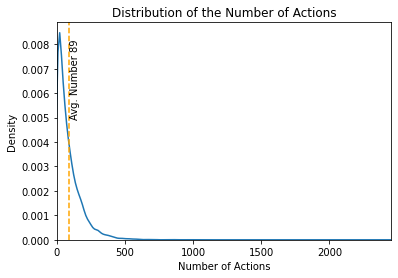

In [37]:
sns.kdeplot(sessions['NoEvents'], alpha=.7)
plt.title('Distribution of the Number of Actions')
plt.axvline(x=np.mean(sessions['NoEvents']), linestyle='--', color='orange')
plt.text(np.mean(sessions['NoEvents'])+1e1,5e-3,'Avg. Number '+str(int(np.mean(sessions['NoEvents']))),rotation=90)
plt.xlabel('Number of Actions')
plt.xlim([0, max(sessions['NoEvents'])])
plt.show()

##### Action State Transition

In [38]:
eventMap = {a:i for i,a in enumerate(set([act for sact in sessions['Event'] for act in sact.split(',')]))}

In [39]:
eventLabels = list(eventMap.keys())

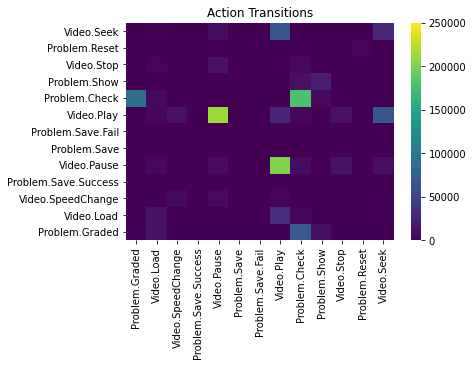

In [40]:
transitionMatrix = transitionEvents(sessions, eventMap)
chart = sns.heatmap(transitionMatrix, vmin=0, vmax=250000, xticklabels=eventLabels, yticklabels=eventLabels, cmap='viridis')
chart.set_title('Action Transitions')
chart.invert_yaxis()

It can be observed that the most meaningful and frequent transitions are **play-to-seek**, **play-to-pause**, and **check-to-graded**. It would be interesting to check whether there are also interesting patterns in the time intervals between events.   

##### Action State Interval

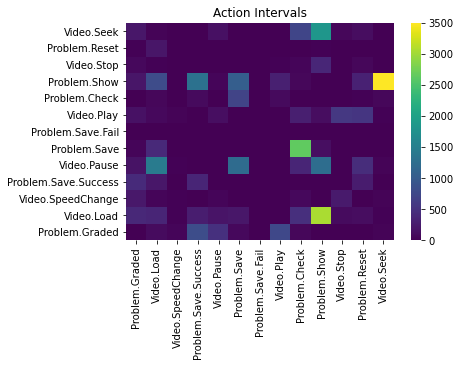

In [41]:
transitionMatrix = transitionIntervals(sessions, eventMap)
chart = sns.heatmap(transitionMatrix, vmin=0, vmax=3500, xticklabels=eventLabels, yticklabels=eventLabels, cmap='viridis')
chart.set_title('Action Intervals')
chart.invert_yaxis()

This transition matrix tells us that there are long intervals for some interesting transitions:
- **intra-video transition**: load-pause;
- **intra-problem events**: show-save and save-check;
- **cross-type events**: problemshow-videoseek, videoseek-problemshow, videopause-problemsave, videostop-problemsave. 

It thus seems that action transitions might characterize students to a good extent in terms of both actions and intervals. Therefore, we generate two feature vectors for each student, one for their transition probabilities and one for their average transition intervals.  

##### Student's Feature Vectors on Action State Transition and Action Interval 

In [42]:
index2UserID = sessions.drop_duplicates(subset=['AccountUserID'], keep='first')['AccountUserID'].values

In [43]:
userID2Index = {str(v):i for i, v in enumerate(sessions.drop_duplicates(subset=['AccountUserID'], keep='first')['AccountUserID'].values)}

In [44]:
index2Round = sessions.drop_duplicates(subset=['AccountUserID'], keep='first')['Round'].values

In [45]:
fvEventTransition = np.zeros((len(set(sessions['AccountUserID'])), 19, len(eventLabels), len(eventLabels)))
for index, (userID, userSessions) in tqdm(enumerate(sessions.groupby('AccountUserID'))):
    fvEventTransition[index] = getStudentWeeklyEventTransitions(userSessions, userSessions['Round'].values[0].split('-')[1], eventMap)

425it [00:05, 77.43it/s]


In [46]:
fvEventIntervals = np.zeros((len(set(sessions['AccountUserID'])), 19, len(eventLabels), len(eventLabels)))
for index, (userID, userSessions) in tqdm(enumerate(sessions.groupby('AccountUserID'))):
    fvEventIntervals[index] = getStudentWeeklyEventIntervals(userSessions, userSessions['Round'].values[0].split('-')[1], eventMap)

425it [00:06, 65.58it/s]


In [47]:
fvWeekEvents = np.zeros((len(set(sessions['AccountUserID'])), 19, len(eventLabels)))
for index, (userID, userSessions) in tqdm(enumerate(sessions.groupby('AccountUserID'))):
    fvWeekEvents[index] = getStudentWeeklyEvents(userSessions, userSessions['Round'].values[0].split('-')[1], eventMap)

425it [00:05, 80.48it/s]


## Investigating Student's Engagement via Session Length

Engagement is an important driver of student's success, and the amount of time spent by student in the platform might be a good proxy of their engamement. Therefore, we explore how much time they spent in the platform along weeks.  

##### Distribution of Session Lenghts

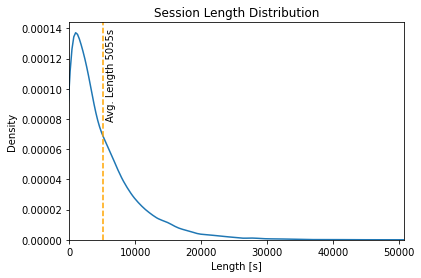

Average duration 5055 seconds


In [48]:
sns.kdeplot(sessions['Duration'], alpha=.7)
plt.title('Session Length Distribution')
plt.axvline(x=np.mean(sessions['Duration']), linestyle='--', color='orange')
plt.text(np.mean(sessions['Duration'])+5e2,8e-5,'Avg. Length '+str(int(np.mean(sessions['Duration']))) + 's',rotation=90)
plt.xlabel('Length [s]')
plt.xlim([0, max(sessions['Duration'])])
plt.show()
print('Average duration', round(np.mean(sessions['Duration'])), 'seconds')

##### Total Number of Actions per Day

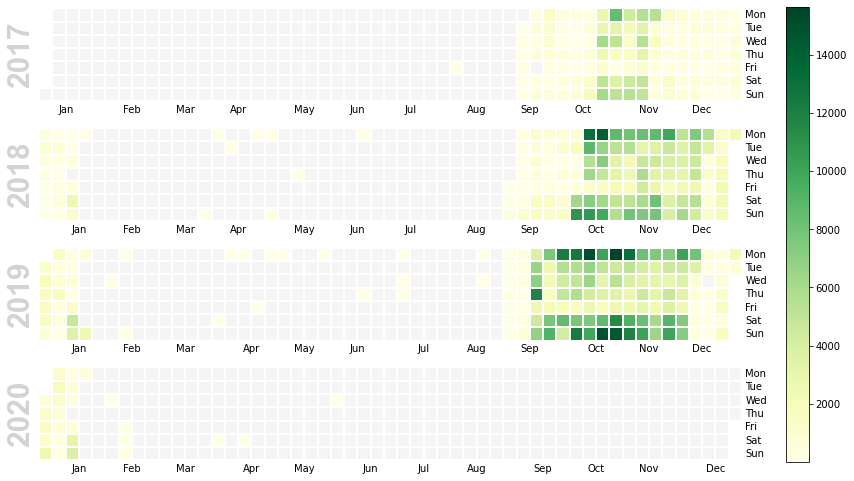

In [49]:
tmpSessions = sessions.copy()
tmpSessions.index = tmpSessions['Start']
calplot.calplot(tmpSessions['NoEvents'], how='sum', cmap='YlGn');

It can be observed that most of the students interact on Saturday, Sunday, and Monday. 

**N.B.** While the total number of actions changes along weeks, the average number of actions per student does not. 

##### Average Session Length per Day

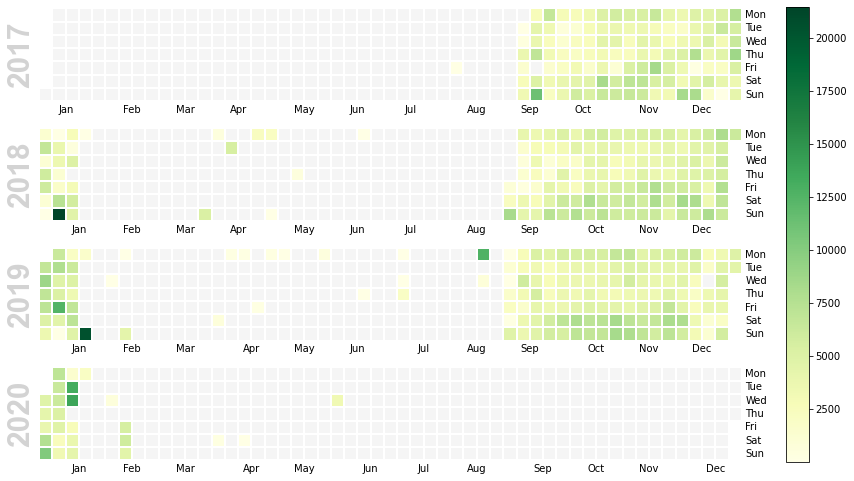

In [50]:
tmpSessions = sessions.copy()
tmpSessions.index = tmpSessions['Start']
calplot.calplot(tmpSessions['Duration'], how='mean', cmap='YlGn');

Though students perform the same amount of actions along weeks on average, the amount of time they spend in performing such actions changes along weeks. It follow that students behave in a more thoughful way in certain periods weeks and weekdays. 

##### Per-Student Session Lenght along Weeks 

In [51]:
fvSessionLength = np.zeros((len(set(sessions['AccountUserID'])), 19))
for index, (userID, userSessions) in enumerate(sessions.groupby('AccountUserID')):
    fvSessionLength[index] = getStudentWeeklySessionLength(userSessions, userSessions['Round'].values[0].split('-')[1])

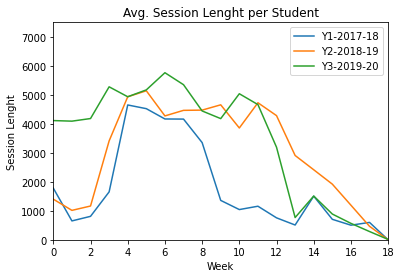

In [52]:
for year in sorted(set(index2Round)):
    plt.plot(np.mean(fvSessionLength[np.where(index2Round == year)[0]], axis=0), label=year)
plt.xlim([0, 18])
plt.ylim([0, 7500])
plt.xlabel('Week')
plt.ylabel('Session Lenght')
plt.title('Avg. Session Lenght per Student')
plt.legend()
plt.show()

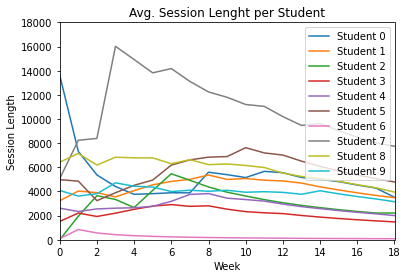

In [53]:
for index, length in enumerate(fvSessionLength[np.where(index2Round == 'Y3-2019-20')[0]][:10]):
    plt.plot(pd.Series(length).rolling(18, min_periods=1).mean(), label='Student ' + str(index))
plt.xlim([0, 18])
plt.ylim([0, 18000])
plt.xlabel('Week')
plt.ylabel('Session Length')
plt.title('Avg. Session Lenght per Student')
plt.legend(loc='upper right')
plt.show()

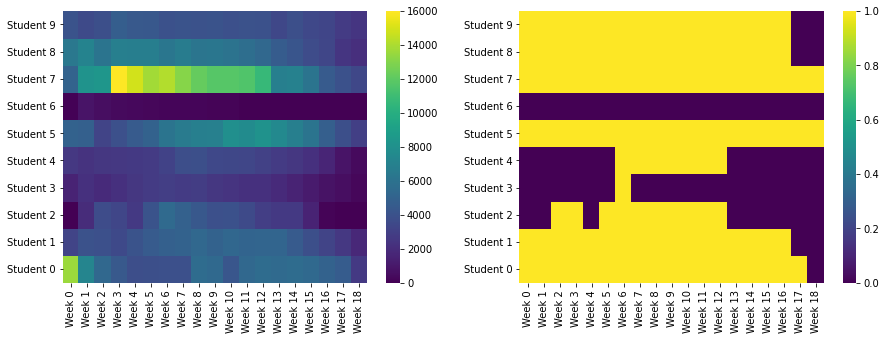

In [54]:
xlabels = ['Week ' + str(i) for i in range(19)]
ylabels = []
series1, series2 = [], []

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for index, length in enumerate(fvSessionLength[np.where(index2Round == 'Y3-2019-20')[0]][:10]):
    series1.append(pd.Series(length).rolling(10, min_periods=1).mean())
    ylabels.append('Student ' + str(index))
chart = sns.heatmap(np.array(series1), xticklabels=xlabels, yticklabels=ylabels, cmap='viridis')
chart.invert_yaxis()

plt.subplot(1, 2, 2)
avgLength = np.mean(fvSessionLength)
for index, length in enumerate(fvSessionLength[np.where(index2Round == 'Y3-2019-20')[0]][:10]):
    series2.append([(1 if value >= avgLength else 0) for value in pd.Series(length).rolling(10, min_periods=1).mean()])
chart = sns.heatmap(np.array(series2), xticklabels=xlabels, yticklabels=ylabels, cmap='viridis')
chart.invert_yaxis()

## Characterizing Groups of Students via Clustering

| Features Set | Shape | Description     | 
|-------------------|------|------|
| fvEventTransitions | (NS,19,13,13) | weekly event transition probabilities per student|
| fvEventIntervals | (NS,19,13,13) | weekly event transition intervals per student |
| fvWeekEvents | (NS,19,13) | weekly event per type per student |
| fvSessionLength | (NS,19) | weekly average session length |

### Clustering students based on their engagement via session length

In [55]:
fvSessionLength = fvSessionLength / np.mean(fvSessionLength)

##### K-Means Clustering

In [56]:
kmeans_kwargs = {'init':'random', 'n_init':10, 'max_iter':300, 'random_state':42}

In [57]:
silhouette_coefficients = []
for k in tqdm(range(2, 11)):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(fvSessionLength)
    score = silhouette_score(fvSessionLength, kmeans.labels_)
    silhouette_coefficients.append(score)

100%|██████████| 9/9 [00:00<00:00, 14.39it/s]


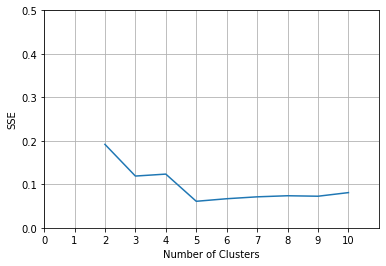

In [58]:
plt.plot(range(2, len(silhouette_coefficients) + 2), silhouette_coefficients)
plt.xticks(range(len(silhouette_coefficients) + 2))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.xlim([0, len(silhouette_coefficients) + 2])
plt.ylim([0, 0.5])
plt.grid()
plt.show()

In [59]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs).fit(fvSessionLength)
for clusterID in set(kmeans.labels_):
    print('Cluster',  str(clusterID) + ':', len(np.where(kmeans.labels_ == clusterID)[0]))

Cluster 0: 167
Cluster 1: 173
Cluster 2: 85


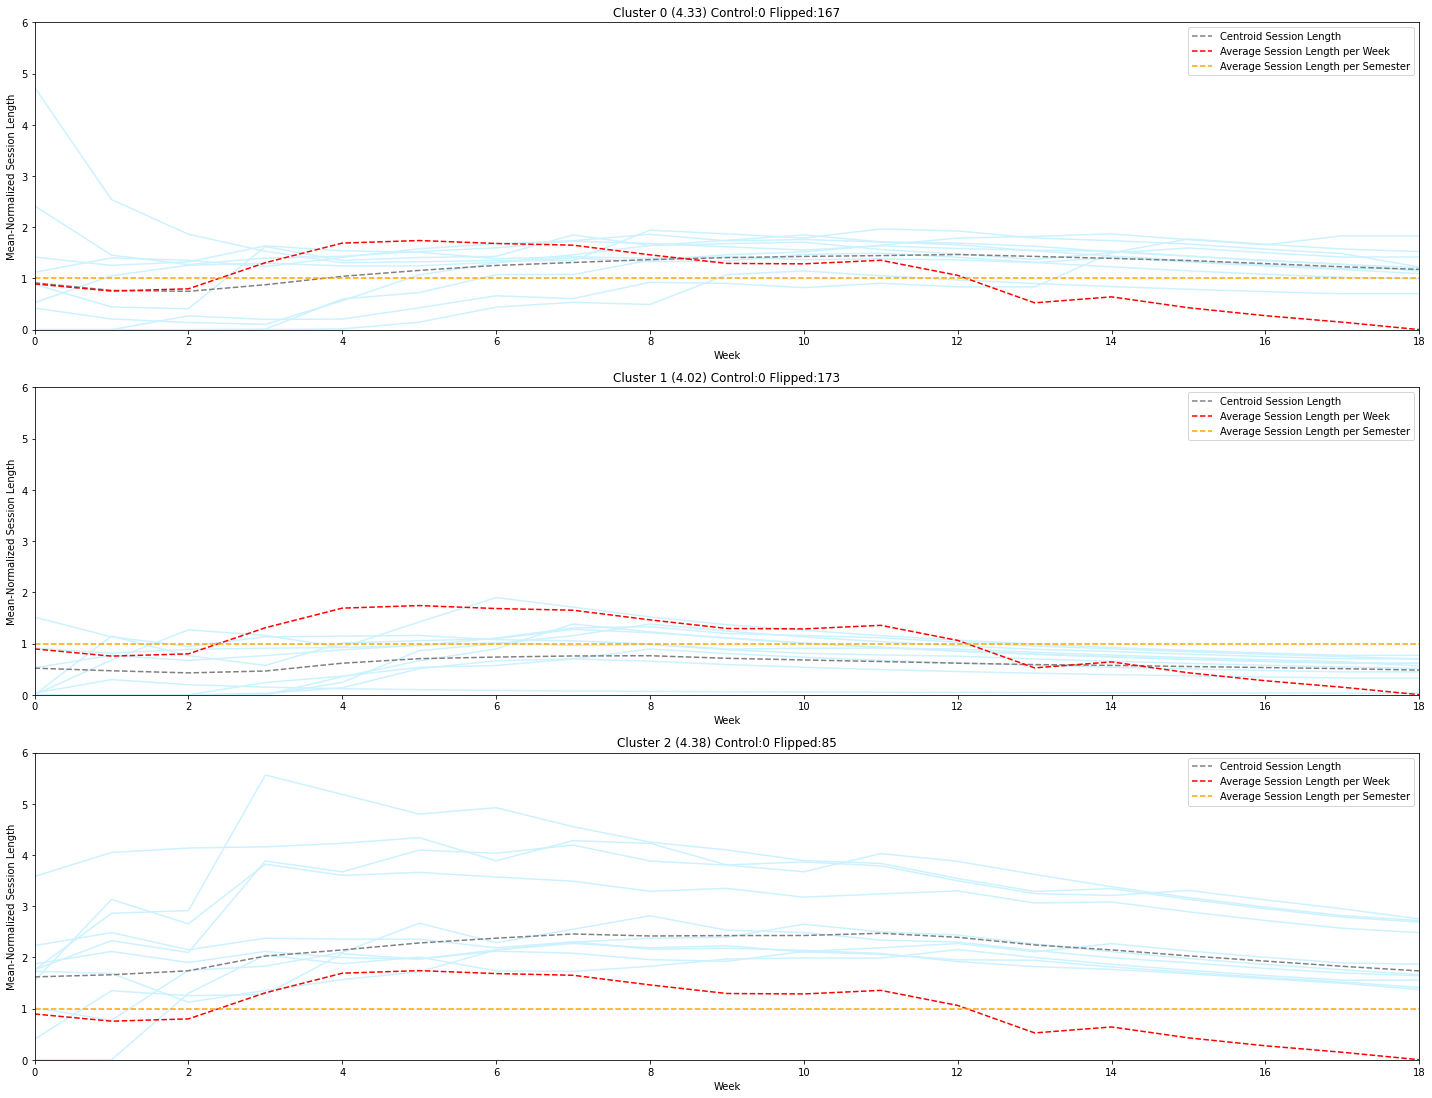

In [60]:
plt.figure(figsize=(20, 20))
cm = plt.cm.get_cmap('tab20c')
for clusterID in set(kmeans.labels_):
    clusterUserIDs = [index2UserID[userID] for userID in np.where(kmeans.labels_ == clusterID)[0]]
    clusterGrades = exam_data[exam_data['AccountUserID'].isin(clusterUserIDs)]['Grade'].values.astype(float)
    conditionIDs = list(user_data[user_data['AccountUserID'].isin(clusterUserIDs)]['Condition'].values)
    centroid = pd.Series(kmeans.cluster_centers_[clusterID]).rolling(18, min_periods=1).mean()
    weekly_centroid = fvSessionLength.mean(0) / np.mean(fvSessionLength)
    plt.subplot(4, 1, clusterID + 1)
    for userID in np.where(kmeans.labels_ == clusterID)[0][:10]: 
        plt.plot(pd.Series(fvSessionLength[userID]).rolling(18, min_periods=1).mean(), color='#CCF2FF')
    plt.plot(centroid, label='Centroid Session Length', linestyle='--', color='grey')
    plt.plot(weekly_centroid, label='Average Session Length per Week', linestyle='--', color='red')  
    plt.axhline(y=np.mean(fvSessionLength), label='Average Session Length per Semester', linestyle='--', color='orange')
    plt.xlim([0, 18])
    plt.ylim([0, 6])
    plt.xlabel('Week')
    plt.ylabel('Mean-Normalized Session Length')
    user_pop = ' Control:' + str(conditionIDs.count('Control')) + ' Flipped:' + str(conditionIDs.count('Flipped'))
    plt.title('Cluster ' + str(clusterID) + ' (' + str(round(np.mean(clusterGrades),2)) + ')' + user_pop)
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

We perform a Mann-Whitney U Test in order to check whether the distributions of two independent samples are equal or not. The assumptions are that (i) observations in each sample are independent and identically distributed, and (ii) observations in each sample can be ranked. 
- **H0**: the distributions of both samples are equal.
- **H1**: the distributions of both samples are not equal.

Cluster 0 : 4.3293413173652695
Cluster 1 : 4.01878612716763
Cluster 2 : 4.376470588235295


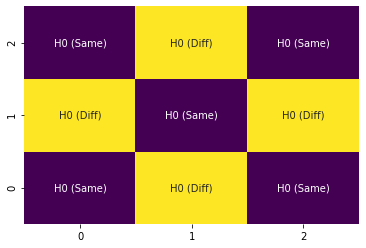

In [61]:
statisticalMatrix = np.zeros((len(set(kmeans.labels_)), len(set(kmeans.labels_))))
for clusterID1 in set(kmeans.labels_):
    clusterUserIDs1 = [index2UserID[userID] for userID in np.where(kmeans.labels_ == clusterID1)[0]]
    clusterGrades1 = exam_data[exam_data['AccountUserID'].isin(clusterUserIDs1)]['Grade'].values
    print('Cluster', str(clusterID1), ':', np.mean(clusterGrades1.astype(float)))
    for clusterID2 in set(kmeans.labels_):
        clusterUserIDs2 = [index2UserID[userID] for userID in np.where(kmeans.labels_ == clusterID2)[0]]
        clusterGrades2 = exam_data[exam_data['AccountUserID'].isin(clusterUserIDs2)]['Grade'].values
        stat, p = mannwhitneyu(clusterGrades1.astype(float), clusterGrades2.astype(float))
        statisticalMatrix[clusterID1, clusterID2] = 0 if p > 0.05 else 1
chart = sns.heatmap(statisticalMatrix, annot=np.array(['H' + str(int(0)) + ' (' + ('Same' if data==0 else 'Diff') + ')' for data in statisticalMatrix.ravel()]).reshape(np.shape(statisticalMatrix)), fmt='', cbar=False, cmap='viridis')
chart.invert_yaxis()

As shown above, KMeans does not always work well. Clusters are generated by k-means with Euclidian distance, and the cluster centroids in grey do not capture the shape of the series. Therefore, we move to a more sophisticated clustering approach. 

##### KMeans Clustering with Dynamic Time Warping

The k-means clustering algorithm can be applied to time series with dynamic time warping with the following modifications.
Dynamic Time Warping (DTW) is used to collect time series of similar shapes. Cluster centroids, or barycenters, are computed with respect to DTW. A barycenter is the average sequence from a group of time series in DTW space. The DTW Barycenter Averaging (DBA) algorithm minimizes sum of squared DTW distance between the barycenter and the series in the cluster. The soft-DTW algorithm minimizes the weighted sum of soft-DTW distances between the barycenter and the series in the cluster. The weights can be tuned but must sum to 1. As a result, the centroids have an average shape that mimics the shape of the members of the cluster, regardless of where temporal shifts occur amongst the members.

In [62]:
silhouette_coefficients = []
for k in tqdm(range(2, 11)):
    kmeans = TimeSeriesKMeans(n_clusters=k, metric='dtw', max_iter=10)
    kmeans.fit(fvSessionLength)
    score = silhouette_score(fvSessionLength, kmeans.labels_)
    silhouette_coefficients.append(score)

100%|██████████| 9/9 [00:56<00:00,  6.33s/it]


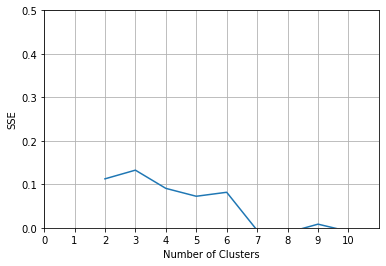

In [63]:
plt.plot(range(2, len(silhouette_coefficients) + 2), silhouette_coefficients)
plt.xticks(range(len(silhouette_coefficients) + 2))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.xlim([0, len(silhouette_coefficients) + 2])
plt.ylim([0, 0.5])
plt.grid()
plt.show()

In [83]:
kmeans = TimeSeriesKMeans(n_clusters=3, metric='dtw', max_iter=10).fit(fvSessionLength)
for clusterID in set(kmeans.labels_):
    print('Cluster',  str(clusterID) + ':', len(np.where(kmeans.labels_ == clusterID)[0]))

Cluster 0: 174
Cluster 1: 154
Cluster 2: 97


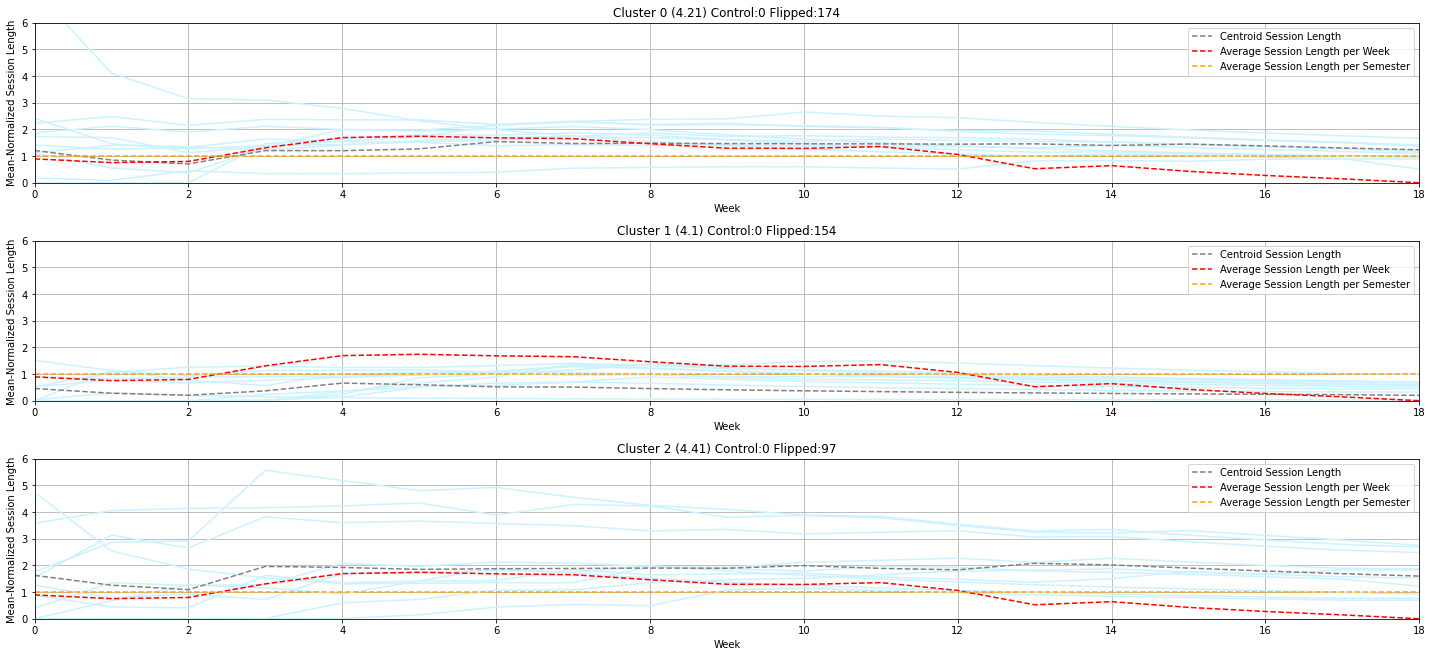

In [90]:
plt.figure(figsize=(20, 10*len(set(kmeans.labels_))))
cm = plt.cm.get_cmap('tab20c')
for clusterID in set(kmeans.labels_):
    clusterUserIDs = [index2UserID[userID] for userID in np.where(kmeans.labels_ == clusterID)[0]]
    clusterGrades = exam_data[exam_data['AccountUserID'].isin(clusterUserIDs)]['Grade'].values.astype(float)
    conditionIDs = list(user_data[user_data['AccountUserID'].isin(clusterUserIDs)]['Condition'].values)
    centroid = pd.Series(np.squeeze(kmeans.cluster_centers_[clusterID])).rolling(18, min_periods=1).mean()
    weekly_centroid = fvSessionLength.mean(0) / np.mean(fvSessionLength)
    plt.subplot(10, 1, clusterID + 1)
    for userID in np.where(kmeans.labels_ == clusterID)[0][:10]: 
        plt.plot(pd.Series(fvSessionLength[userID]).rolling(18, min_periods=1).mean(), color='#CCF2FF')
    plt.plot(centroid, label='Centroid Session Length', linestyle='--', color='grey')
    plt.plot(weekly_centroid, label='Average Session Length per Week', linestyle='--', color='red')   
    plt.axhline(y=np.mean(fvSessionLength), label='Average Session Length per Semester', linestyle='--', color='orange')
    plt.xlim([0, 18])
    plt.ylim([0, 6])
    plt.xlabel('Week')
    plt.ylabel('Mean-Normalized Session Length')
    user_pop = ' Control:' + str(conditionIDs.count('Control')) + ' Flipped:' + str(conditionIDs.count('Flipped'))
    plt.title('Cluster ' + str(clusterID) + ' (' + str(round(np.mean(clusterGrades),2)) + ')' + user_pop)
    plt.legend(loc='upper right')
    plt.grid()
plt.tight_layout()
plt.show()

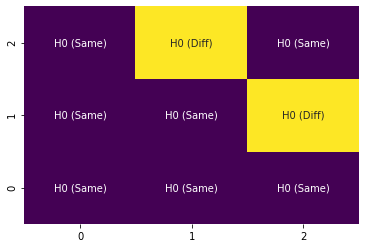

In [85]:
statisticalMatrix = np.zeros((len(set(kmeans.labels_)), len(set(kmeans.labels_))))
for clusterID1 in set(kmeans.labels_):
    clusterUserIDs1 = [index2UserID[userID] for userID in np.where(kmeans.labels_ == clusterID1)[0]]
    clusterGrades1 = exam_data[exam_data['AccountUserID'].isin(clusterUserIDs1)]['Grade'].values
    for clusterID2 in set(kmeans.labels_):
        clusterUserIDs2 = [index2UserID[userID] for userID in np.where(kmeans.labels_ == clusterID2)[0]]
        clusterGrades2 = exam_data[exam_data['AccountUserID'].isin(clusterUserIDs2)]['Grade'].values
        stat, p = mannwhitneyu(clusterGrades1.astype(float), clusterGrades2.astype(float))
        statisticalMatrix[clusterID1, clusterID2] = 0 if p > 0.05 else 1
chart = sns.heatmap(statisticalMatrix, annot=np.array(['H' + str(int(0)) + ' (' + ('Same' if data==0 else 'Diff') + ')' for data in statisticalMatrix.ravel()]).reshape(np.shape(statisticalMatrix)), fmt='', cbar=False, cmap='viridis')
chart.invert_yaxis()

### Clustering Students based on Intra-Session Event Transitions

In [76]:
fvReshaped = fvWeekEvents[:,:,eventLabels.index('Video.Play')]

In [77]:
fvReshaped = fvReshaped / np.mean(fvReshaped)

In [78]:
silhouette_coefficients = []
for k in tqdm(range(2, 11)):
    kmeans = TimeSeriesKMeans(n_clusters=k, metric='dtw', max_iter=10)
    kmeans.fit(fvReshaped)
    score = silhouette_score(fvReshaped, kmeans.labels_)
    silhouette_coefficients.append(score)

100%|██████████| 9/9 [00:47<00:00,  5.33s/it]


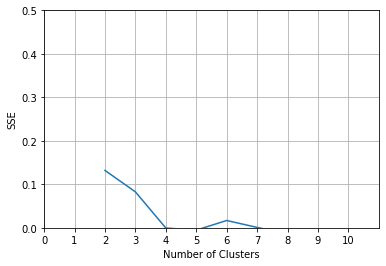

In [79]:
plt.plot(range(2, len(silhouette_coefficients) + 2), silhouette_coefficients)
plt.xticks(range(len(silhouette_coefficients) + 2))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.xlim([0, len(silhouette_coefficients) + 2])
plt.ylim([0, 0.5])
plt.grid()
plt.show()

In [80]:
kmeans = TimeSeriesKMeans(n_clusters=3, metric='dtw', max_iter=10).fit(fvReshaped)
for clusterID in set(kmeans.labels_):
    print('Cluster',  str(clusterID) + ':', len(np.where(kmeans.labels_ == clusterID)[0]))

Cluster 0: 85
Cluster 1: 174
Cluster 2: 166


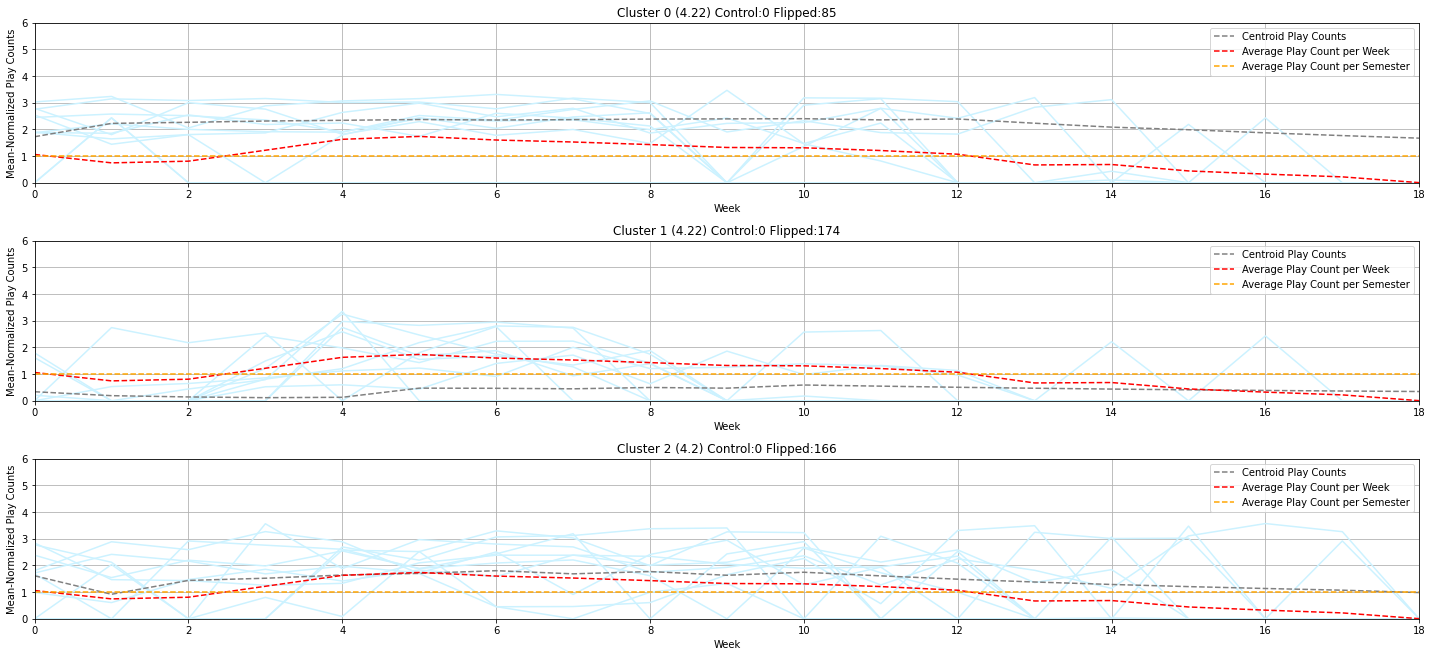

In [81]:
plt.figure(figsize=(20, 10*len(set(kmeans.labels_))))
cm = plt.cm.get_cmap('tab20c')
for clusterID in set(kmeans.labels_):
    clusterUserIDs = [index2UserID[userID] for userID in np.where(kmeans.labels_ == clusterID)[0]]
    clusterGrades = exam_data[exam_data['AccountUserID'].isin(clusterUserIDs)]['Grade'].values.astype(float)
    conditionIDs = list(user_data[user_data['AccountUserID'].isin(clusterUserIDs)]['Condition'].values)
    centroid = pd.Series(np.squeeze(kmeans.cluster_centers_[clusterID])).rolling(18, min_periods=1).mean()
    weekly_centroid = fvReshaped.mean(0) / np.mean(fvReshaped)
    plt.subplot(10, 1, clusterID + 1)
    for userID in np.where(kmeans.labels_ == clusterID)[0][:10]: 
        plt.plot(pd.Series(fvReshaped[userID]), color='#CCF2FF')
    plt.plot(centroid, label='Centroid Play Counts', linestyle='--', color='grey')
    plt.plot(weekly_centroid, label='Average Play Count per Week', linestyle='--', color='red')   
    plt.axhline(y=np.mean(fvReshaped), label='Average Play Count per Semester', linestyle='--', color='orange')
    plt.xlim([0, 18])
    plt.ylim([0, 6])
    plt.xlabel('Week')
    plt.ylabel('Mean-Normalized Play Counts')
    user_pop = ' Control:' + str(conditionIDs.count('Control')) + ' Flipped:' + str(conditionIDs.count('Flipped'))
    plt.title('Cluster ' + str(clusterID) + ' (' + str(round(np.mean(clusterGrades),2)) + ')' + user_pop)
    plt.legend(loc='upper right')
    plt.grid()
plt.tight_layout()
plt.show()

##### Questions
- Can average session length per week caharacterize groups of students?
- Do the clusters remain the same across weeks?
- Can a ML model predict the engagement of a student on the next week?
- Can a ML model predict when a student will start to lose engagement?